In [17]:
!pip install catboost

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from mlxtend.plotting import plot_decision_regions

import warnings
warnings.filterwarnings('ignore')

In [19]:
# Feature Engineering Function
def feature_engineering(df):
    df = df.copy()
    df.replace(['nan', 'NaN', 'null', 'None'], np.nan, inplace=True)

    df['GLU_GLT_ratio'] = df['LBXGLU'] / (df['LBXGLT'] + 1e-5)
    df['INSULIN_GLU_product'] = df['LBXIN'] * df['LBXGLU']
    df['BMI_INSULIN'] = df['BMXBMI'] * df['LBXIN']
    df['GLU_age_ratio'] = df['LBXGLU'] / (df['RIDAGEYR'] + 1e-5)
    df['BMI_age_ratio'] = df['BMXBMI'] / (df['RIDAGEYR'] + 1e-5)

    if 'PAQ605' in df.columns:
        df['PAQ605_flag'] = (df['PAQ605'] == 1).astype(int)
    if 'DIQ010' in df.columns:
        df['DIQ010_flag'] = (df['DIQ010'] == 1).astype(int)

    return df

In [20]:
# Load and Prepare Training Data
df = pd.read_csv('Train_Data.csv')
df = df.dropna(subset=['age_group'])

df = feature_engineering(df)

# Encode labels
le = LabelEncoder()
df['age_group'] = le.fit_transform(df['age_group'])

# Separate features and target
X = df.drop(columns=['SEQN', 'age_group'])
y = df['age_group']

# Impute missing values
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

EDA Summary:
               SEQN     RIDAGEYR     RIAGENDR       PAQ605       BMXBMI  \
count   1940.000000  1943.000000  1934.000000  1939.000000  1934.000000   
mean   78685.510825    41.986104     1.509307     1.825683    27.981127   
std     2927.348984    20.123750     0.500043     0.399355     7.343856   
min    73564.000000    12.000000     1.000000     1.000000    14.500000   
25%    76188.250000    24.000000     1.000000     2.000000    22.800000   
50%    78719.000000    41.000000     2.000000     2.000000    26.800000   
75%    81222.750000    58.000000     2.000000     2.000000    31.300000   
max    83727.000000    80.000000     2.000000     7.000000    70.100000   

            LBXGLU       DIQ010       LBXGLT        LBXIN    age_group  \
count  1939.000000  1934.000000  1941.000000  1943.000000  1952.000000   
mean     99.466220     2.015512   115.070067    11.875265     0.160861   
std      16.738574     0.186916    46.133851     9.779149     0.367497   
min      63.000

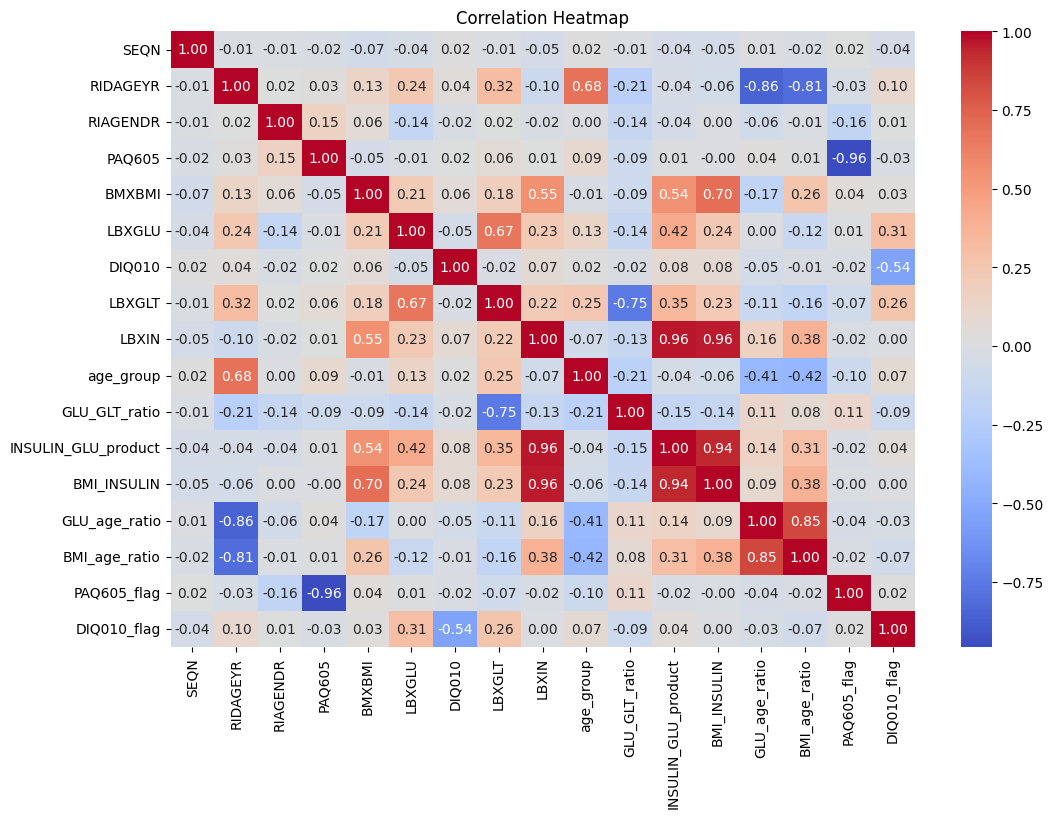

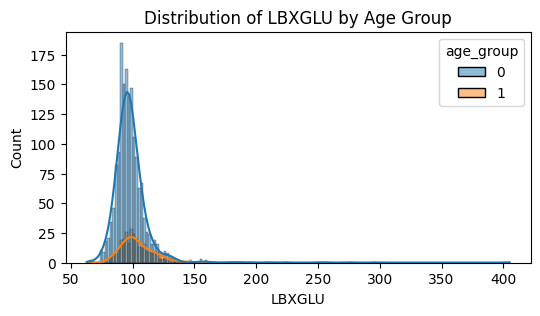

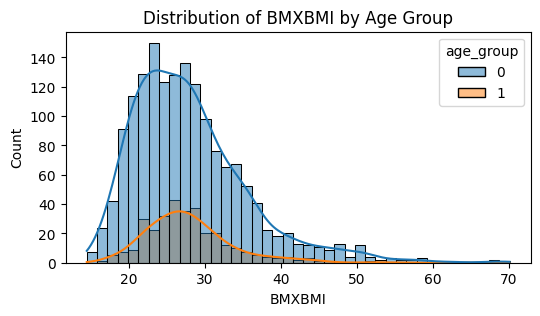

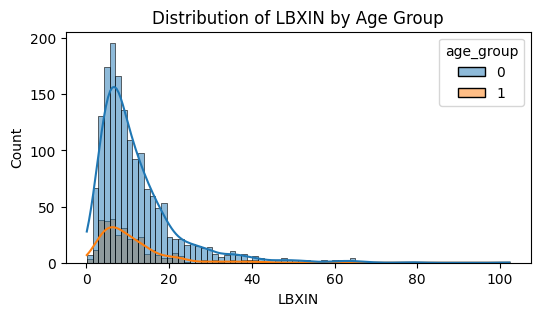

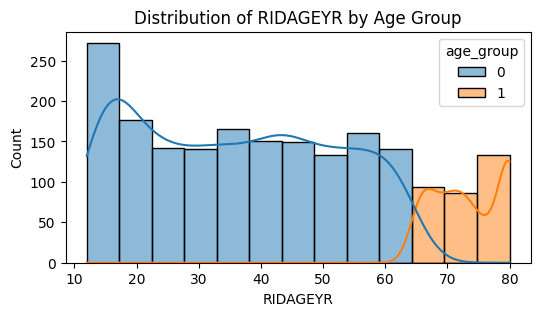

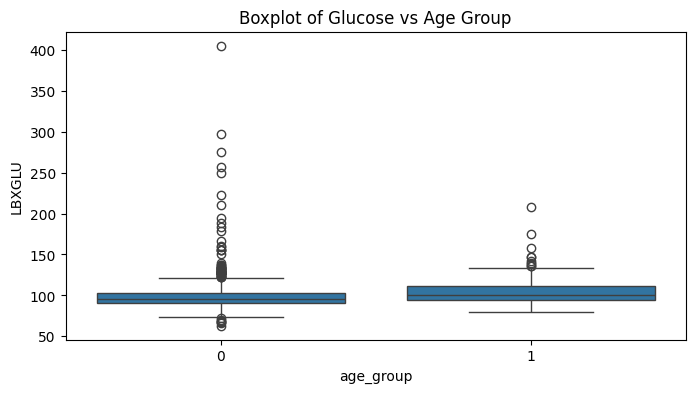

In [21]:
# EDA Section
print("EDA Summary:")
print(df.describe())

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Distribution plots
features_to_plot = ['LBXGLU', 'BMXBMI', 'LBXIN', 'RIDAGEYR']
for feat in features_to_plot:
    plt.figure(figsize=(6, 3))
    sns.histplot(data=df, x=feat, hue='age_group', kde=True)
    plt.title(f'Distribution of {feat} by Age Group')
    plt.show()

# Boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x='age_group', y='LBXGLU', data=df)
plt.title('Boxplot of Glucose vs Age Group')
plt.show()

In [22]:
# Define base model
cat_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=0
)

# Hyperparameter search space
param_dist = {
    'iterations': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [3, 4, 5, 6, 7, 8],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 1, 3, 5],
    'border_count': [32, 64, 128]
}

# Randomized search with cross-validation
random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='accuracy',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)

# Fit search
random_search.fit(X_imputed, y)

# Best model and score
print("Best Parameters:", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)

# Use best model for final fit
final_model = random_search.best_estimator_
final_model.fit(X_imputed, y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'learning_rate': 0.2, 'l2_leaf_reg': 5, 'iterations': 200, 'depth': 5, 'border_count': 64, 'bagging_temperature': 3}
Best CV Accuracy: 0.9994871794871795


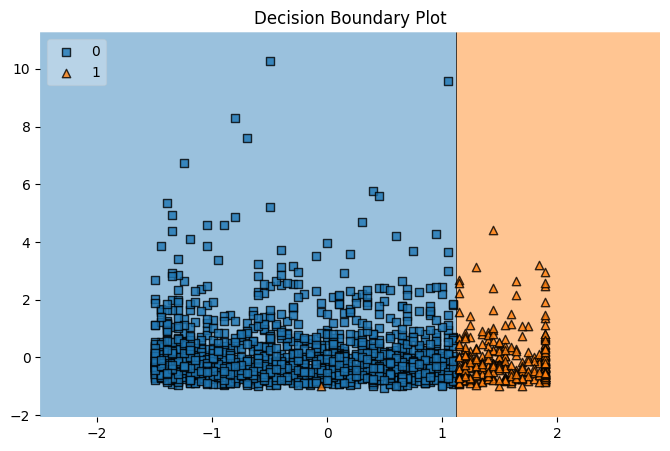

In [23]:
# Decision Boundary Plot (using top 2 features)
# Reduce to 2D using top 2 most important features for decision boundary
importances = final_model.get_feature_importance(prettified=True)
top2 = importances.sort_values('Importances', ascending=False).iloc[:2]['Feature Id'].values
# Change .iloc to .loc to select columns by name
X_2d = X_imputed.loc[:, top2]

# Normalize for plotting
scaler = StandardScaler()
X_2d_scaled = scaler.fit_transform(X_2d)

model_boundary = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=4, verbose=0)
model_boundary.fit(X_2d_scaled, y)

plt.figure(figsize=(8, 5))
plot_decision_regions(X_2d_scaled, y.values, clf=model_boundary, legend=2)
plt.title("Decision Boundary Plot")
plt.show()

In [24]:
# Prediction and Submission
test_data = pd.read_csv('Test_Data.csv')
test_ids = test_data['SEQN']

test_data = feature_engineering(test_data)

X_test = test_data[X.columns]
X_test = X_test.replace(['nan', 'NaN', 'null', 'None'], np.nan)
for col in X_test.columns:
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X.columns)

test_preds = final_model.predict(X_test_imputed)

submission = pd.DataFrame({
    'Id': test_ids,
    'age_group': test_preds  # Keep as 0/1
})
submission['Id'] = submission['Id'].fillna(-1).astype(float)

submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully.")

Submission file 'submission.csv' created successfully.


In [25]:
#Check submission data
subm = pd.read_csv('submission.csv')
subm['age_group'].value_counts()

,count
age_group,
0,266
1,46
